<h1><span style="color:steelblue"> Book Recommendation System </span></h1>

In [1]:
import warnings
import phik
import string
import nltk

import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader as gdl

from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from scipy.sparse import csr_matrix

%matplotlib inline

In [2]:
#Displaying max columns and rows:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Suppressing FutureWarning:
warnings.simplefilter(action='ignore', category=FutureWarning)

## <span style="color:steelblue"> Data Preprocessing and EDA</span>

<em><span style="color:lightsteelblue"> Load Data</span></em>

In [3]:
books = pd.read_csv('data/books_enriched.csv')
ratings = pd.read_csv('data/ratings.csv')

<div class="alert alert-block alert-info">
    
- This dataset contains six million ratings for ten thousand most popular (with most ratings) books.<br><br>
- Each book may have many editions. goodreads_book_id and best_book_id generally point to the most popular edition of a given book, while goodreads work_id refers to the book in the abstract sense.<br><br>
- Note that book_id in ratings.csv maps to work_id, not to goodreads_book_id, meaning that ratings for different editions are aggregated.

<em><span style="color:lightsteelblue"> View ratings data </span></em>

In [4]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [5]:
num_ratings = ratings['rating'].count()

print(f'There are {num_ratings:,} total ratings.')

There are 5,976,479 total ratings.


In [6]:
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()

print(f'The ratings range from {min_rating} to {max_rating}.')

The ratings range from 1 to 5.


In [7]:
num_users = ratings['user_id'].nunique()

print(f'There are {num_users:,} users in total.')

There are 53,424 users in total.


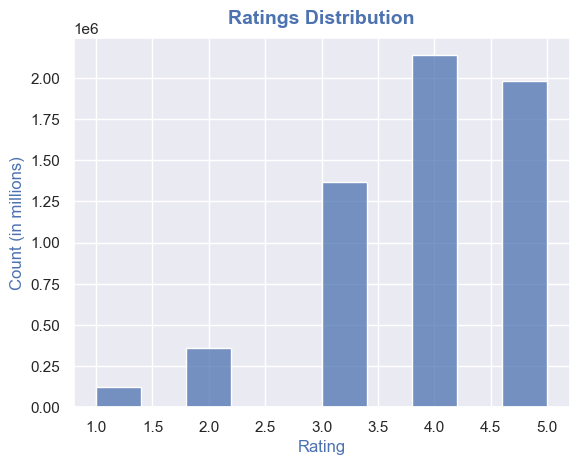

In [8]:
sns.set_theme()
sns.histplot(x=ratings['rating'], bins=10)
plt.xlabel('Rating', fontsize=12, c='#4c72b0')
plt.ylabel('Count (in millions)', fontsize=12, c='#4c72b0')
plt.title('Ratings Distribution', size=14,\
          pad=10, fontweight='bold', color='#4c72b0')

plt.show()

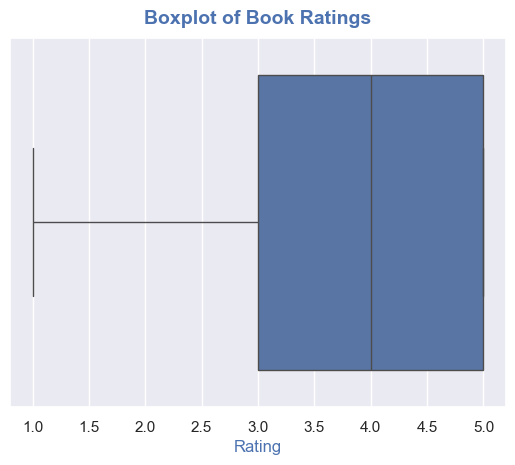

In [9]:
sns.boxplot(x=ratings['rating'], orient='h')
plt.xlabel('Rating', fontsize=12, c='#4c72b0')
plt.title('Boxplot of Book Ratings', size=14, pad=10, fontweight='bold', color='#4c72b0')

plt.show()

<em><span style="color:lightsteelblue"> View books data</span></em>

In [10]:
books.head()

,Unnamed: 0,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,image_url,isbn,isbn13,language_code,original_publication_year,original_title,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2
0,0,0,['Suzanne Collins'],4.34,2767052,1,272,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,439023483,9.780439e+12,eng,2008.0,The Hunger Games,374.0,09/14/08,66715,127936,560092,1481305,2706317,4780653,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254,['Suzanne Collins']
1,1,1,"['J.K. Rowling', 'Mary GrandPré']",4.44,3,2,491,Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,439554934,9.780440e+12,eng,1997.0,Harry Potter and the Philosopher's Stone,309.0,11/01/03,75504,101676,455024,1156318,3011543,4602479,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867,"['J.K. Rowling', 'Mary GrandPré']"
2,2,2,['Stephenie Meyer'],3.57,41865,3,226,About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,316015849,9.780316e+12,eng,2005.0,Twilight,501.0,09/06/06,456191,436802,793319,875073,1355439,3866839,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,3916824,95009,['Stephenie Meyer']
3,3,3,['Harper Lee'],4.25,2657,4,487,The unforgettable novel of a childhood in a sl...,"['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,61120081,9.780061e+12,eng,1960.0,To Kill a Mockingbird,324.0,05/23/06,60427,117415,446835,1001952,1714267,3198671,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,3340896,72586,['Harper Lee']
4,4,4,['F. Scott Fitzgerald'],3.89,4671,5,1356,Alternate Cover Edition ISBN: 0743273567 (ISBN...,"['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,743273567,9.780743e+12,eng,1925.0,The Great Gatsby,200.0,09/28/04,86236,197621,606158,936012,947718,2683664,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,2773745,51992,['F. Scott Fitzgerald']


In [11]:
top_rated = books[books['average_rating'] >= 4.5]
top_rated_count = top_rated['work_id'].count()
print(f'There are {top_rated_count} books with an average rating of 4.5 or greater.')

There are 144 books with an average rating of 4.5 or greater.


In [12]:
mid_rated = books[(books['average_rating'] > 2.5) & (books['average_rating'] < 4.5)]
mid_rated_count = mid_rated['work_id'].count()
print(f'There are {mid_rated_count:,} books with an average rating greater than 2.5 but less than 4.5.')

There are 9,855 books with an average rating greater than 2.5 but less than 4.5.


In [13]:
low_rated = books[books['average_rating'] <= 2.5]
low_rated_count = low_rated['work_id'].count()
print(f'There is {low_rated_count} book with an average rating of 2.5 or less.')

There is 1 book with an average rating of 2.5 or less.


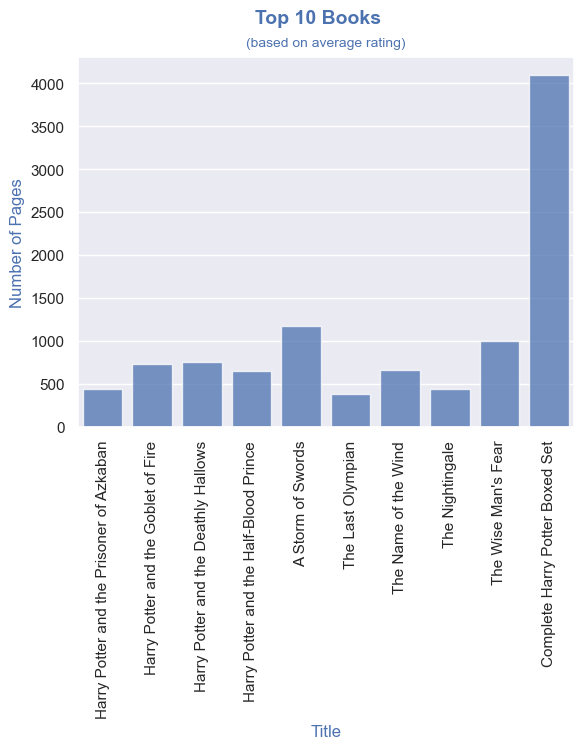

In [14]:
top_10_books = top_rated[:10]

sns.barplot(data=top_10_books,
            x='original_title', y='pages', alpha=.75, saturation=100)
plt.xlabel('Title', fontsize=12, c='#4c72b0')
plt.xticks(rotation=90)
plt.ylabel('Number of Pages', fontsize=12, c='#4c72b0')
plt.suptitle('Top 10 Books', size=14, fontweight='bold', color='#4c72b0')
plt.title('(based on average rating)', size=10, pad=8, c='#4c72b0')

plt.show()

<em><span style="color:lightsteelblue"> Compare books in ratings df to books in books df  </span></em>

In [15]:
# 'book_id' in ratings df correspond to 'work_id' in books df.

ratings.rename(columns={'book_id':'work_id'}, inplace=True)

In [16]:
print(ratings['work_id'].nunique())
print(books['work_id'].nunique())

10000
10000


In [17]:
matched_ids = ratings[ratings['work_id'].isin(books['work_id'])]
matched_ids_count = matched_ids['work_id'].nunique()

print(f'There are {matched_ids_count} books in the books df that have been rated.')

There are 176 books in the books df that have been rated.


In [18]:
unmatched_ids = ratings[~ratings['work_id'].isin(books['work_id'])]
unmatched_ids_count = unmatched_ids['work_id'].nunique()

print(f'There are {unmatched_ids_count} books from the books df that have not been rated.')
print(f'There are {unmatched_ids_count} books that have been rated but do not exist in the books df.')

There are 9824 books from the books df that have not been rated.
There are 9824 books that have been rated but do not exist in the books df.


<em><span style="color:lightsteelblue"> Remove books that don't exist in books df from ratings df  </span></em>

In [19]:
ratings['work_id'] = matched_ids['work_id']

In [20]:
ratings.head()

,user_id,work_id,rating
0,1,NaN,5
1,2,NaN,4
2,2,NaN,5
3,2,NaN,5
4,2,NaN,3


In [21]:
ratings.dropna(inplace=True)

In [22]:
ratings['work_id'] = ratings['work_id'].astype('int64')

In [23]:
ratings.head()

,user_id,work_id,rating
60,8,362,5
84,4,87,5
169,11,574,3
181,11,115,4
209,15,87,5


In [24]:
print(ratings['work_id'].dtype)
print(books['work_id'].dtype)

int64
int64


In [25]:
print(ratings['work_id'].nunique())
print(books['work_id'].nunique())

176
10000


<div class="alert alert-block alert-info">
    
- The ratings df suggest that only 176 books from the books df have been rated. The other 9,824 rated books found in the ratings df do not exist in the books df. 
<br><br>
- The average rating in the books df indicates that all 10,000 books in the books df have been rated.
<br><br>
- average_rating in the books df may not reflect the same ratings as the ratings df.

<em><span style="color:lightsteelblue"> Merge books df with ratings df </span></em>

In [26]:
goodbooks = books.merge(ratings, how='left', on='work_id')

In [27]:
goodbooks.head()

,Unnamed: 0,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,image_url,isbn,isbn13,language_code,original_publication_year,original_title,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2,user_id,rating
0,0,0,['Suzanne Collins'],4.34,2767052,1,272,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,439023483,9.780439e+12,eng,2008.0,The Hunger Games,374.0,09/14/08,66715,127936,560092,1481305,2706317,4780653,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254,['Suzanne Collins'],NaN,NaN
1,1,1,"['J.K. Rowling', 'Mary GrandPré']",4.44,3,2,491,Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,439554934,9.780440e+12,eng,1997.0,Harry Potter and the Philosopher's Stone,309.0,11/01/03,75504,101676,455024,1156318,3011543,4602479,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867,"['J.K. Rowling', 'Mary GrandPré']",NaN,NaN
2,2,2,['Stephenie Meyer'],3.57,41865,3,226,About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,316015849,9.780316e+12,eng,2005.0,Twilight,501.0,09/06/06,456191,436802,793319,875073,1355439,3866839,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,3916824,95009,['Stephenie Meyer'],NaN,NaN
3,3,3,['Harper Lee'],4.25,2657,4,487,The unforgettable novel of a childhood in a sl...,"['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,61120081,9.780061e+12,eng,1960.0,To Kill a Mockingbird,324.0,05/23/06,60427,117415,446835,1001952,1714267,3198671,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,3340896,72586,['Harper Lee'],NaN,NaN
4,4,4,['F. Scott Fitzgerald'],3.89,4671,5,1356,Alternate Cover Edition ISBN: 0743273567 (ISBN...,"['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,743273567,9.780743e+12,eng,1925.0,The Great Gatsby,200.0,09/28/04,86236,197621,606158,936012,947718,2683664,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,2773745,51992,['F. Scott Fitzgerald'],NaN,NaN


<em><span style="color:lightsteelblue">Clean [user_id] and [rating]</span></em>

In [28]:
goodbooks['user_id'].fillna(0, inplace=True)
goodbooks['rating'].fillna(0, inplace=True)

In [29]:
goodbooks.head()

,Unnamed: 0,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,image_url,isbn,isbn13,language_code,original_publication_year,original_title,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2,user_id,rating
0,0,0,['Suzanne Collins'],4.34,2767052,1,272,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,439023483,9.780439e+12,eng,2008.0,The Hunger Games,374.0,09/14/08,66715,127936,560092,1481305,2706317,4780653,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254,['Suzanne Collins'],0.0,0.0
1,1,1,"['J.K. Rowling', 'Mary GrandPré']",4.44,3,2,491,Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,439554934,9.780440e+12,eng,1997.0,Harry Potter and the Philosopher's Stone,309.0,11/01/03,75504,101676,455024,1156318,3011543,4602479,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867,"['J.K. Rowling', 'Mary GrandPré']",0.0,0.0
2,2,2,['Stephenie Meyer'],3.57,41865,3,226,About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,316015849,9.780316e+12,eng,2005.0,Twilight,501.0,09/06/06,456191,436802,793319,875073,1355439,3866839,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,3916824,95009,['Stephenie Meyer'],0.0,0.0
3,3,3,['Harper Lee'],4.25,2657,4,487,The unforgettable novel of a childhood in a sl...,"['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,61120081,9.780061e+12,eng,1960.0,To Kill a Mockingbird,324.0,05/23/06,60427,117415,446835,1001952,1714267,3198671,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,3340896,72586,['Harper Lee'],0.0,0.0
4,4,4,['F. Scott Fitzgerald'],3.89,4671,5,1356,Alternate Cover Edition ISBN: 0743273567 (ISBN...,"['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,743273567,9.780743e+12,eng,1925.0,The Great Gatsby,200.0,09/28/04,86236,197621,606158,936012,947718,2683664,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,2773745,51992,['F. Scott Fitzgerald'],0.0,0.0


In [30]:
goodbooks['user_id'] = goodbooks['user_id'].astype('int64')
goodbooks['rating'] = goodbooks['rating'].astype('int64')

In [31]:
print(goodbooks['user_id'].dtypes)
print(goodbooks['rating'].dtypes)

int64
int64


In [32]:
goodbooks.sample(5)

,Unnamed: 0,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,image_url,isbn,isbn13,language_code,original_publication_year,original_title,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2,user_id,rating
21944,1586,1586,['Frank Herbert'],4.35,53764,1687,18,"Herbert's evocative, epic tales are set on the...","['science-fiction', 'fiction', 'fantasy', 'cla...",53764,https://images.gr-assets.com/books/1419962914m...,575070706,9.780575e+12,eng,1977.0,The Great Dune Trilogy,912.0,November 17th 2005,623,1404,5995,14927,29133,51454,https://images.gr-assets.com/books/1419962914s...,The Great Dune Trilogy,551,52082,165,['Frank Herbert'],19195,3
86259,5157,5157,['Jon Lee Anderson'],4.10,10836,5809,44,"""Acclaimed around the world and a national bes...","['biography', 'history', 'nonfiction', 'philos...",10836,https://s.gr-assets.com/assets/nophoto/book/11...,802135587,9.780802e+12,eng,1997.0,Che Guevara: A Revolutionary Life,814.0,March 9th 1998,299,473,2502,5120,5777,13516,https://s.gr-assets.com/assets/nophoto/book/50...,Che Guevara: A Revolutionary Life,3455,14171,540,['Jon Lee Anderson'],11406,3
42692,2795,2795,['Barbara Taylor Bradford'],4.16,8155,3003,61,"A celebration of an indomitable spirit, here i...","['fiction', 'romance', 'historical-fiction', '...",8155,https://images.gr-assets.com/books/1330029941m...,031235326X,9.780312e+12,eng,1979.0,A Woman of Substance,928.0,December 1st 2005,412,1129,5996,10664,14731,31309,https://images.gr-assets.com/books/1330029941s...,A Woman of Substance (Emma Harte Saga #1),87,32932,614,['Barbara Taylor Bradford'],43377,5
21122,1586,1586,['Frank Herbert'],4.35,53764,1687,18,"Herbert's evocative, epic tales are set on the...","['science-fiction', 'fiction', 'fantasy', 'cla...",53764,https://images.gr-assets.com/books/1419962914m...,575070706,9.780575e+12,eng,1977.0,The Great Dune Trilogy,912.0,November 17th 2005,623,1404,5995,14927,29133,51454,https://images.gr-assets.com/books/1419962914s...,The Great Dune Trilogy,551,52082,165,['Frank Herbert'],14727,4
8939,348,348,['Billie Letts'],4.00,5168,381,54,"Talk about unlucky sevens. An hour ago, sevent...","['fiction', 'chick-lit', 'romance', 'contempor...",5168,https://images.gr-assets.com/books/1327959469m...,446672211,9.780447e+12,eng,1995.0,Where the Heart Is,376.0,June 1st 1998,2053,8967,48023,79147,72178,208333,https://images.gr-assets.com/books/1327959469s...,Where the Heart Is,1649,210368,3147,['Billie Letts'],52344,4


<em><span style="color:lightsteelblue">Check shape of data</span></em>

In [33]:
goodbooks.shape

(140010, 32)

<em><span style="color:lightsteelblue">View missing values</span></em>

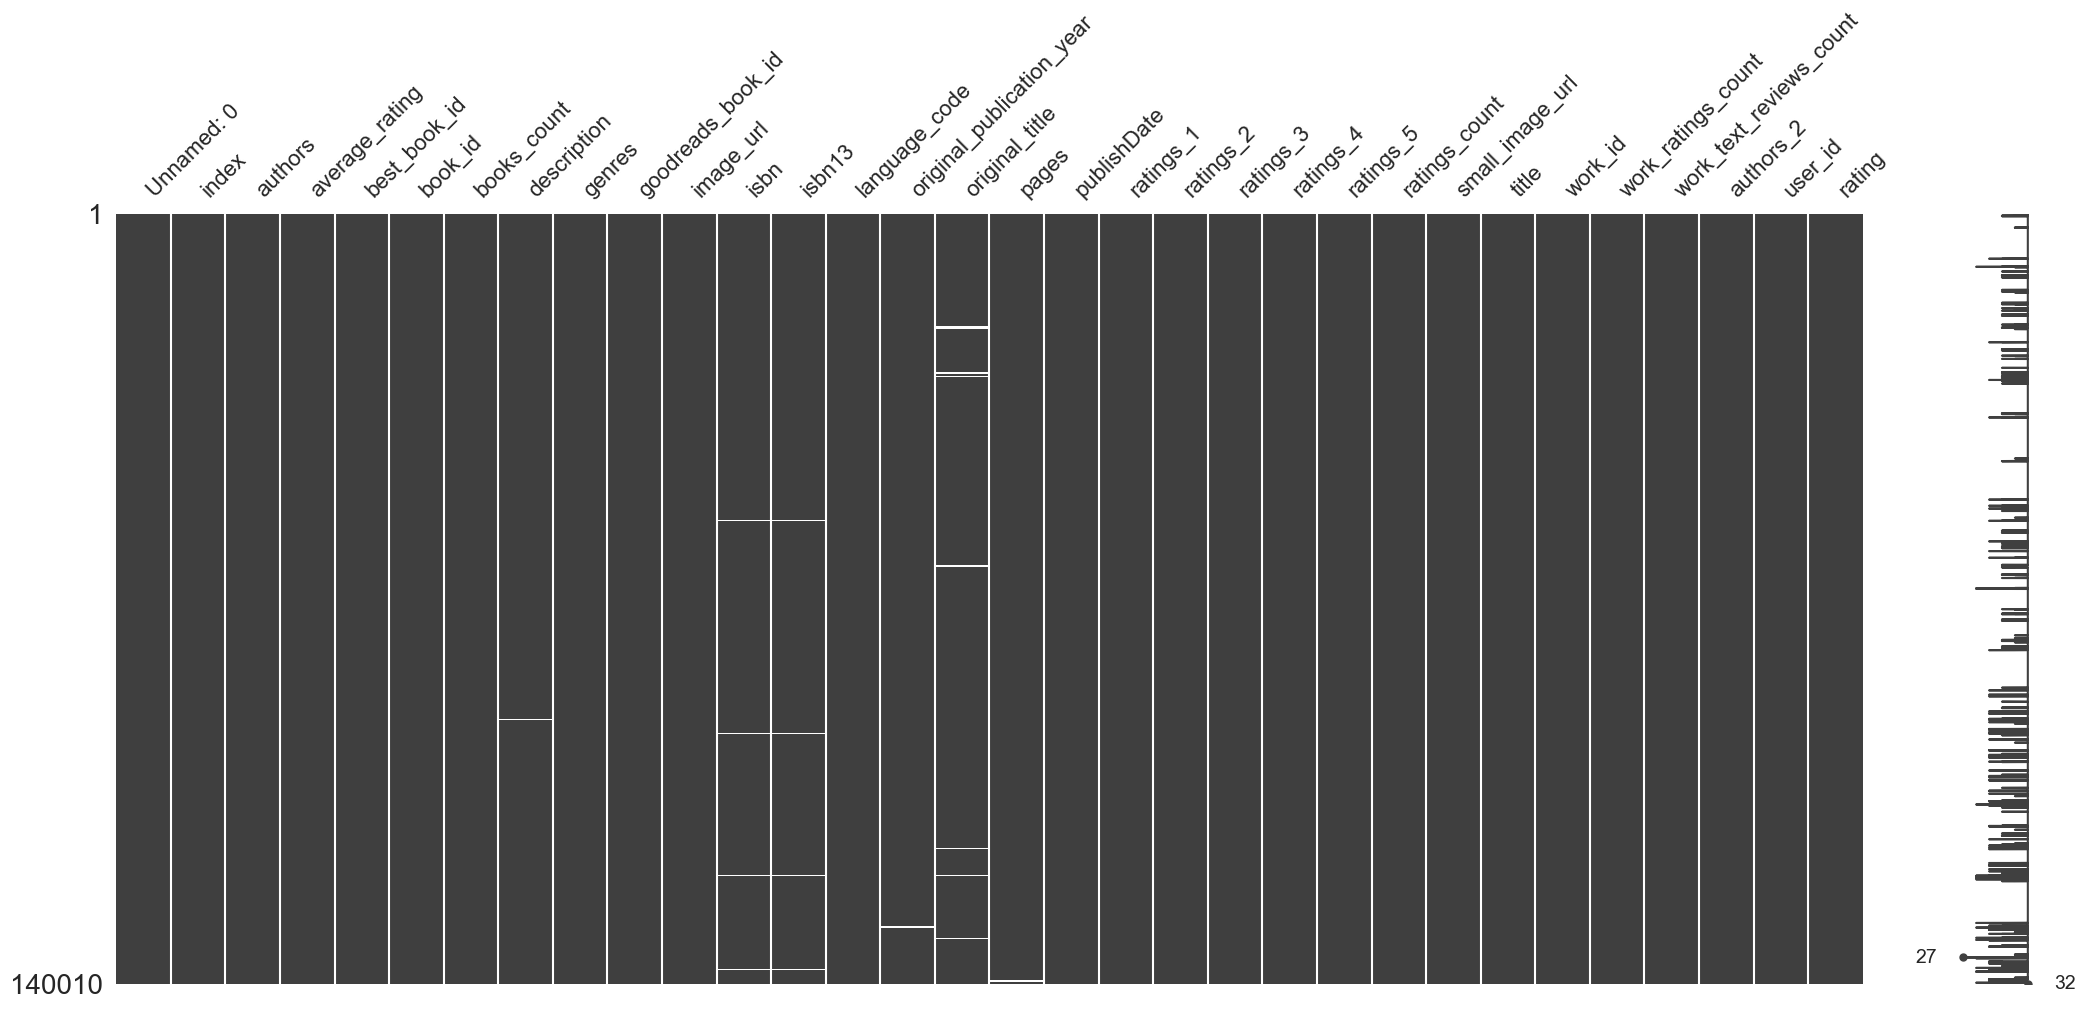

In [34]:
msno.matrix(goodbooks)
plt.show()

<em><span style="color:lightsteelblue">Confirm duplicate column</span></em>

In [35]:
author_df = goodbooks[['authors', 'authors_2']]
author_df.sample(5)

,authors,authors_2
133907,"['[Michael Rosen', 'Jane E. Ray]']","['[Michael Rosen', 'Jane E. Ray]']"
102147,['Oscar Wilde'],['Oscar Wilde']
108672,['Brian Jacques'],['Brian Jacques']
71003,['Neil Strauss'],['Neil Strauss']
35643,['Patricia Schultz'],['Patricia Schultz']


In [36]:
unmatched_authors = author_df[~author_df['authors'].isin(author_df['authors_2'])]
unmatched_authors['authors'].nunique()

0

<em><span style="color:lightsteelblue">Drop redundant columns and columns containing missing values</span></em>

In [37]:
goodbooks.drop(columns=['Unnamed: 0', 'index', 'average_rating', 
                        'best_book_id', 'isbn', 'isbn13',
                        'original_publication_year', 'original_title',
                        'pages','publishDate', 'authors_2'], inplace=True)

<em><span style="color:lightsteelblue">Recheck shape</span></em>

In [38]:
goodbooks.shape

(140010, 21)

<em><span style="color:lightsteelblue">Handle missing values in [description]</span></em>

In [39]:
goodbooks['description'].isna().sum()

209

In [40]:
goodbooks.dropna(subset=['description'], inplace=True)

In [41]:
goodbooks['description'].isna().sum()

0

<em><span style="color:lightsteelblue">Recheck shape</span></em>

In [42]:
goodbooks.shape

(139801, 21)

<em><span style="color:lightsteelblue">Generate profile report (add. EDA) </span></em>

In [43]:
goodbooks_report = ProfileReport(goodbooks.sample(10000, random_state=42),
                                vars={'num':{'low_categorical_threshold':0}},
                                correlations={'auto': {'calculate':False}})
goodbooks_report.to_file('goodbooks_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<em><span style="color:lightsteelblue">Drop imbalanced column</span></em>

In [44]:
goodbooks.drop(columns=['language_code'], inplace=True)

In [45]:
goodbooks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139801 entries, 0 to 140009
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   authors                  139801 non-null  object
 1   book_id                  139801 non-null  int64 
 2   books_count              139801 non-null  int64 
 3   description              139801 non-null  object
 4   genres                   139801 non-null  object
 5   goodreads_book_id        139801 non-null  int64 
 6   image_url                139801 non-null  object
 7   ratings_1                139801 non-null  int64 
 8   ratings_2                139801 non-null  int64 
 9   ratings_3                139801 non-null  int64 
 10  ratings_4                139801 non-null  int64 
 11  ratings_5                139801 non-null  int64 
 12  ratings_count            139801 non-null  int64 
 13  small_image_url          139801 non-null  object
 14  title               

<em><span style="color:lightsteelblue">Select features using phik correlations and p-values</span></em>

In [46]:
goodbooks_phik = goodbooks.copy()
interval_columns = ['book_id', 'books_count', 'goodreads_book_id',
                    'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4',
                    'ratings_5', 'ratings_count','work_id', 'work_ratings_count',
                    'work_text_reviews_count','user_id']

for c in goodbooks_phik.columns:
    if c not in interval_columns:
        goodbooks_phik[c] = goodbooks_phik[c].astype('category')

In [47]:
phik_correlations = []
phik_significances = []
columns = goodbooks_phik.columns
y = goodbooks_phik['rating']

for c in columns:
    x = goodbooks_phik[c]
    if c in interval_columns:
        phik_correlations.append(phik.phik_from_array(x,y,[c]))
        phik_significances.append(phik.significance.significance_from_array(x,y,[c])[0])
    else:
        phik_correlations.append(phik.phik_from_array(x,y))
        phik_significances.append(phik.significance.significance_from_array(x,y)[0])

C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 5028. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 5028. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 9772. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 9772. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The nu

In [48]:
phik_df = pd.DataFrame({'phik': phik_correlations, 'p-value': phik_significances},
                      index=columns)
phik_df.sort_values(by='phik', ascending=False, inplace=True)

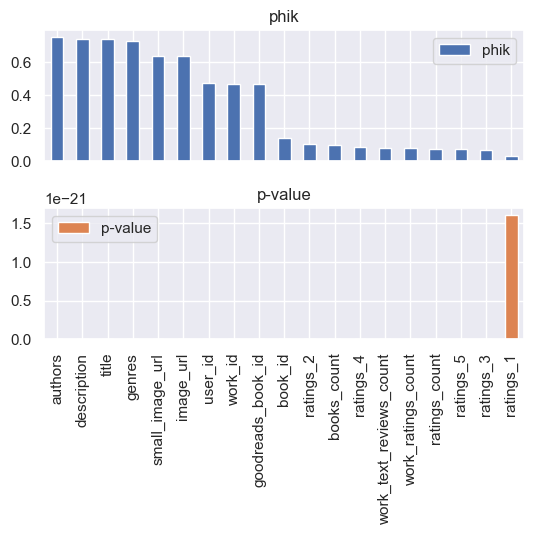

In [49]:
phik_df.iloc[1:].plot.bar(subplots=True, figsize=(5.5,5.5))
plt.tight_layout()
plt.show()

In [50]:
goodbooks.drop(columns=['book_id', 'ratings_2', 'books_count', 'ratings_4',
                        'work_text_reviews_count', 'work_ratings_count', 
                        'ratings_count', 'ratings_5', 'ratings_3',
                        'ratings_1'], inplace=True)

<em><span style="color:lightsteelblue">Recheck shape</span></em>

In [51]:
goodbooks.shape

(139801, 10)

<em><span style="color:lightsteelblue">Clean [authors] and [title]</span></em>

In [52]:
goodbooks.head(3)

,authors,description,genres,goodreads_book_id,image_url,small_image_url,title,work_id,user_id,rating
0,['Suzanne Collins'],WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,0,0
1,"['J.K. Rowling', 'Mary GrandPré']",Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,0,0
2,['Stephenie Meyer'],About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,0,0


In [53]:
goodbooks['title'] = goodbooks['title'].str.replace(r'\s*\(.*?\)\s*', ' ', regex=True)
goodbooks['title'] = goodbooks['title'].str.strip()

In [54]:
goodbooks['authors'] = goodbooks['authors'].str.replace(r"[\[\]'']", '', regex=True).str.strip()
goodbooks['authors'] = goodbooks['authors'].apply((lambda x: x.split(',')[0].split(';')[0].strip()))

In [55]:
goodbooks.head(3)

,authors,description,genres,goodreads_book_id,image_url,small_image_url,title,work_id,user_id,rating
0,Suzanne Collins,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games,2792775,0,0
1,J.K. Rowling,Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone,4640799,0,0
2,Stephenie Meyer,About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,Twilight,3212258,0,0


<em><span style="color:lightsteelblue">(add. EDA)</span></em>

In [56]:
authors = goodbooks['authors'].value_counts()
top_10_authors = authors[:10]
top_10_authors

Plum Sykes                 7564
Isabel Allende             6792
Barbara Taylor Bradford    6466
Wilson Rawls               5615
M.M. Kaye                  5467
Patricia Schultz           5408
Neil Strauss               3560
Max Brooks                 3225
Anonymous                  2507
Frank Herbert              2314
Name: authors, dtype: int64

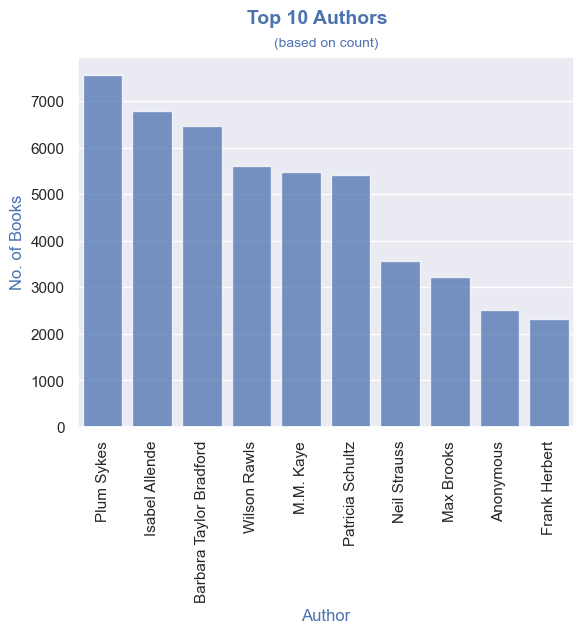

In [57]:
sns.barplot(data=top_10_authors, alpha=.75, saturation=100)
plt.xlabel('Author', fontsize=12, c='#4c72b0')
plt.xticks(rotation=90)
plt.ylabel('No. of Books', fontsize=12, c='#4c72b0')
plt.suptitle('Top 10 Authors', size=14, fontweight='bold', color='#4c72b0')
plt.title('(based on count)', size=10, pad=8, c='#4c72b0')

plt.show()

<em><span style="color:lightsteelblue">Prep [authors] for embeddings</span></em>

In [58]:
authors_1 = goodbooks['authors'].copy()
authors_1[:10]

0        Suzanne Collins
1           J.K. Rowling
2        Stephenie Meyer
3             Harper Lee
4    F. Scott Fitzgerald
5             John Green
6         J.R.R. Tolkien
7          J.D. Salinger
8              Dan Brown
9            Jane Austen
Name: authors, dtype: object

In [59]:
translator = str.maketrans('', '', string.punctuation + string.digits)
authors_1 = authors_1.apply(lambda x: x.translate(translator))
authors_1[:10]

0       Suzanne Collins
1            JK Rowling
2       Stephenie Meyer
3            Harper Lee
4    F Scott Fitzgerald
5            John Green
6           JRR Tolkien
7           JD Salinger
8             Dan Brown
9           Jane Austen
Name: authors, dtype: object

In [60]:
authors_1 = authors_1.str.lower()
authors_1[:10]

0       suzanne collins
1            jk rowling
2       stephenie meyer
3            harper lee
4    f scott fitzgerald
5            john green
6           jrr tolkien
7           jd salinger
8             dan brown
9           jane austen
Name: authors, dtype: object

<em><span style="color:lightsteelblue">Prep [description] for embeddings</span></em>

In [61]:
goodbooks['description'][:10]

0    WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...
1    Harry Potter's life is miserable. His parents ...
2    About three things I was absolutely positive.\...
3    The unforgettable novel of a childhood in a sl...
4    Alternate Cover Edition ISBN: 0743273567 (ISBN...
5    Despite the tumor-shrinking medical miracle th...
6    In a hole in the ground there lived a hobbit. ...
7    The hero-narrator of The Catcher in the Rye is...
8    World-renowned Harvard symbologist Robert Lang...
9    Alternate cover edition of ISBN 9780679783268S...
Name: description, dtype: object

In [62]:
goodbooks['description'] = goodbooks['description'].apply(lambda x: x.translate(translator))
goodbooks['description'][:10]

0    WINNING MEANS FAME AND FORTUNELOSING MEANS CER...
1    Harry Potters life is miserable His parents ar...
2    About three things I was absolutely positive\n...
3    The unforgettable novel of a childhood in a sl...
4    Alternate Cover Edition ISBN  ISBN The Great G...
5    Despite the tumorshrinking medical miracle tha...
6    In a hole in the ground there lived a hobbit N...
7    The heronarrator of The Catcher in the Rye is ...
8    Worldrenowned Harvard symbologist Robert Langd...
9    Alternate cover edition of ISBN Since its imme...
Name: description, dtype: object

In [63]:
goodbooks['description'] = goodbooks['description'].str.lower()
goodbooks['description'][:10]

0    winning means fame and fortunelosing means cer...
1    harry potters life is miserable his parents ar...
2    about three things i was absolutely positive\n...
3    the unforgettable novel of a childhood in a sl...
4    alternate cover edition isbn  isbn the great g...
5    despite the tumorshrinking medical miracle tha...
6    in a hole in the ground there lived a hobbit n...
7    the heronarrator of the catcher in the rye is ...
8    worldrenowned harvard symbologist robert langd...
9    alternate cover edition of isbn since its imme...
Name: description, dtype: object

In [64]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
en_stopwords = stopwords.words('english')
en_stopwords = set(en_stopwords)

In [66]:
def filter_description(desc):
    words = desc.split() 
    filtered_words = [w for w in words if w not in en_stopwords and len(w) > 3]
    return ' '.join(filtered_words)

In [67]:
goodbooks['description'] = goodbooks['description'].apply(filter_description)
goodbooks['description'][:10]

0    winning means fame fortunelosing means certain...
1    harry potters life miserable parents dead stuc...
2    three things absolutely positive first edward ...
3    unforgettable novel childhood sleepy southern ...
4    alternate cover edition isbn isbn great gatsby...
5    despite tumorshrinking medical miracle bought ...
6    hole ground lived hobbit nasty dirty hole fill...
7    heronarrator catcher ancient child sixteen nat...
8    worldrenowned harvard symbologist robert langd...
9    alternate cover edition isbn since immediate s...
Name: description, dtype: object

In [68]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [69]:
goodbooks['description'] = goodbooks['description'].apply(word_tokenize)
goodbooks['description'][:10]

0    [winning, means, fame, fortunelosing, means, c...
1    [harry, potters, life, miserable, parents, dea...
2    [three, things, absolutely, positive, first, e...
3    [unforgettable, novel, childhood, sleepy, sout...
4    [alternate, cover, edition, isbn, isbn, great,...
5    [despite, tumorshrinking, medical, miracle, bo...
6    [hole, ground, lived, hobbit, nasty, dirty, ho...
7    [heronarrator, catcher, ancient, child, sixtee...
8    [worldrenowned, harvard, symbologist, robert, ...
9    [alternate, cover, edition, isbn, since, immed...
Name: description, dtype: object

<em><span style="color:lightsteelblue">Inspect [genres]</span></em>

In [70]:
goodbooks['genres'][:10]

0    ['young-adult', 'fiction', 'fantasy', 'science...
1    ['fantasy', 'fiction', 'young-adult', 'classics']
2    ['young-adult', 'fantasy', 'romance', 'fiction...
3    ['classics', 'fiction', 'historical-fiction', ...
4    ['classics', 'fiction', 'historical-fiction', ...
5    ['young-adult', 'romance', 'fiction', 'contemp...
6    ['fantasy', 'classics', 'fiction', 'young-adult']
7               ['classics', 'fiction', 'young-adult']
8    ['fiction', 'mystery', 'thriller', 'suspense',...
9    ['classics', 'fiction', 'romance', 'historical...
Name: genres, dtype: object

<em><span style="color:lightsteelblue">Load transfer learning model</span></em>

In [71]:
w2v_path = gdl.load("word2vec-google-news-300", return_path=True)

In [72]:
w2v_model = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

<em><span style="color:lightsteelblue">Create embeddings (Content-based filtering)</span></em>

In [73]:
def get_average_embedding(text, model):
    if not text:
        return np.zeros(model.vector_size)
    vectors = [model[t] for t in text if t in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

In [74]:
goodbooks['auth_embeddings'] = authors_1.apply(lambda x: get_average_embedding(x, w2v_model))

In [75]:
goodbooks['desc_embeddings'] = goodbooks['description'].apply(lambda x: get_average_embedding(x, w2v_model))

In [76]:
goodbooks['genr_embeddings'] = goodbooks['genres'].apply(lambda x: get_average_embedding(x, w2v_model))

In [77]:
goodbooks.head()

,authors,description,genres,goodreads_book_id,image_url,small_image_url,title,work_id,user_id,rating,auth_embeddings,desc_embeddings,genr_embeddings
0,Suzanne Collins,"[winning, means, fame, fortunelosing, means, c...","['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games,2792775,0,0,"[-0.13034762, 0.07092285, 0.014272837, 0.11232...","[0.034551818, 0.07394084, 0.0451905, 0.0879799...","[-0.18049137, 0.0805679, 0.01200755, 0.1453291..."
1,J.K. Rowling,"[harry, potters, life, miserable, parents, dea...","['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone,4640799,0,0,"[-0.180386, 0.04296197, 0.005689833, 0.168023,...","[0.0453708, 0.046102505, 0.0064881225, 0.03284...","[-0.19840567, 0.093826294, 0.024034772, 0.1241..."
2,Stephenie Meyer,"[three, things, absolutely, positive, first, e...","['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,Twilight,3212258,0,0,"[-0.15208653, 0.13817488, -0.029453823, 0.1671...","[0.057015877, -0.0043905755, 0.04261045, 0.076...","[-0.17471313, 0.09913366, 0.00080422795, 0.133..."
3,Harper Lee,"[unforgettable, novel, childhood, sleepy, sout...","['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,0,0,"[-0.14762878, 0.18591309, -0.044067383, 0.1402...","[0.08347933, 0.011099372, 0.008116279, 0.07396...","[-0.20613137, 0.09310991, 0.014219627, 0.13086..."
4,F. Scott Fitzgerald,"[alternate, cover, edition, isbn, isbn, great,...","['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,0,0,"[-0.22053222, 0.123099774, -0.007519531, 0.135...","[0.009168668, 0.052608237, -0.045570202, 0.136...","[-0.20284526, 0.093082, 0.0030788844, 0.144999..."


<em><span style="color:lightsteelblue">Combine embeddings</span></em>

In [78]:
def combine_embeddings(row):
    return row['auth_embeddings'] + row['desc_embeddings'] + row['genr_embeddings']

In [79]:
goodbooks['comb_embeddings'] = goodbooks.apply(combine_embeddings, axis=1)

In [80]:
goodbooks.head()

,authors,description,genres,goodreads_book_id,image_url,small_image_url,title,work_id,user_id,rating,auth_embeddings,desc_embeddings,genr_embeddings,comb_embeddings
0,Suzanne Collins,"[winning, means, fame, fortunelosing, means, c...","['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games,2792775,0,0,"[-0.13034762, 0.07092285, 0.014272837, 0.11232...","[0.034551818, 0.07394084, 0.0451905, 0.0879799...","[-0.18049137, 0.0805679, 0.01200755, 0.1453291...","[-0.2762872, 0.22543159, 0.07147089, 0.3456325..."
1,J.K. Rowling,"[harry, potters, life, miserable, parents, dea...","['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone,4640799,0,0,"[-0.180386, 0.04296197, 0.005689833, 0.168023,...","[0.0453708, 0.046102505, 0.0064881225, 0.03284...","[-0.19840567, 0.093826294, 0.024034772, 0.1241...","[-0.33342087, 0.18289077, 0.036212727, 0.32501..."
2,Stephenie Meyer,"[three, things, absolutely, positive, first, e...","['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,Twilight,3212258,0,0,"[-0.15208653, 0.13817488, -0.029453823, 0.1671...","[0.057015877, -0.0043905755, 0.04261045, 0.076...","[-0.17471313, 0.09913366, 0.00080422795, 0.133...","[-0.2697838, 0.23291796, 0.013960856, 0.376933..."
3,Harper Lee,"[unforgettable, novel, childhood, sleepy, sout...","['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,0,0,"[-0.14762878, 0.18591309, -0.044067383, 0.1402...","[0.08347933, 0.011099372, 0.008116279, 0.07396...","[-0.20613137, 0.09310991, 0.014219627, 0.13086...","[-0.27028084, 0.29012236, -0.021731477, 0.3450..."
4,F. Scott Fitzgerald,"[alternate, cover, edition, isbn, isbn, great,...","['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,0,0,"[-0.22053222, 0.123099774, -0.007519531, 0.135...","[0.009168668, 0.052608237, -0.045570202, 0.136...","[-0.20284526, 0.093082, 0.0030788844, 0.144999...","[-0.41420883, 0.26879, -0.05001085, 0.41632354..."


<em><span style="color:lightsteelblue">Create sparse matrix (Collaborative filtering)</span></em>

In [81]:
goodbooks_pivot = goodbooks.pivot_table(columns='user_id', 
                                        index='title', 
                                        values='rating')

In [82]:
goodbooks_sparse = csr_matrix(goodbooks_pivot)

In [83]:
goodbooks_sparse

<9746x48511 sparse matrix of type '<class 'numpy.float64'>'
	with 472778632 stored elements in Compressed Sparse Row format>